# Reduced Dimension MFPT Analysis

In [399]:
import tempfile
import os
import numpy as np
from msmbuilder.example_datasets import FsPeptide
from msmbuilder.dataset import dataset
from msmbuilder.featurizer import DihedralFeaturizer
from sklearn.decomposition import PCA
import mdtraj as md
import msmbuilder.utils as msmUtils
from msmbuilder.tpt import mfpts
import matplotlib.pyplot as plt
from scipy import stats
import scipy

In [2]:
%matplotlib inline

In [3]:
# Base path for all files
#base = 'C:\Users\MinCheol\Documents\TJ_data'
base = 'C:\\Users\\minch_000\\Documents\\TJ_data'

## FsPeptide Analysis

### ISOMAP

#### MFPT vs Distance in ISOMAP Space

In [429]:
# import the msm, raw XYZ coordinates, and the cluster assignments
fs_msm = msmUtils.load(base + '\\fspeptide\msm\msm.pkl')
X_rd = np.load(base + '\\fspeptide\\reduced_dimension\\X_isomap_40_40_10000.dat')
cluster_assignments = np.loadtxt(base + '\\fspeptide\msm\msm_clustering_labels.csv', delimiter=',')
chosen_indices = np.loadtxt(base + '\\fspeptide\msm\indices_12000.csv', delimiter=',')

In [430]:
# Collect MFPT
#fs_mfpt_matrix = (mfpts(fs_msm) + mfpts(fs_msm).transpose())
fs_mfpt_matrix = mfpts(fs_msm)

In [441]:
# Parameters for MFPT plots
num_frames = X_rd.shape[0]
num_points = 500

In [442]:
distances = []
mfpt_times = []
for p in range(num_points):
    frame_pair = np.random.randint(low=0, high=num_frames-1, size=2) # frame number in sim_data
    #true_frame_pair = frame_pair
    true_frame_pair = (int(chosen_indices[frame_pair[0]]), int(chosen_indices[frame_pair[1]])) # corresponding original frame numbers
    msm_frame_pair = (fs_msm.mapping_[cluster_assignments[true_frame_pair[0]]], fs_msm.mapping_[cluster_assignments[true_frame_pair[1]]])
    rd_distance = np.linalg.norm(X_rd[frame_pair[0],:] - X_rd[frame_pair[1], :], 2)
    if msm_frame_pair[0] != msm_frame_pair[1]:
        distances.append(rd_distance)
        mfpt_times.append(np.mean([fs_mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]],fs_mfpt_matrix[msm_frame_pair[1]][msm_frame_pair[0]]]))

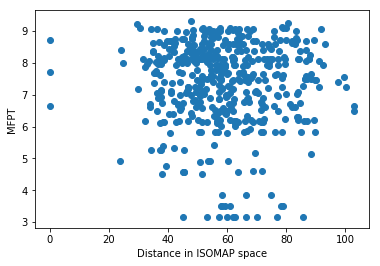

In [443]:
x = np.array(distances)
y = np.log(np.array(mfpt_times))
plt.scatter(x, y)
plt.xlabel('Distance in ISOMAP space')
plt.ylabel('MFPT')

#### Flux vs Distance in ISOMAP space

In [435]:
# Get flux matrix
Pi = np.diag(fs_msm.populations_)
Pi = scipy.linalg.fractional_matrix_power(Pi, 1)
Pi_L = scipy.linalg.fractional_matrix_power(Pi, 0.5)
Pi_R = scipy.linalg.fractional_matrix_power(Pi, -0.5)
T = fs_msm.transmat_
flux = np.linalg.multi_dot([Pi_L,T,Pi_R])

In [436]:
# Parameters for MFPT plots
num_frames = X_rd.shape[0]
num_points = 100000

In [437]:
distances = []
fluxes = []
for p in range(num_points):
    frame_pair = np.random.randint(low=0, high=num_frames-1, size=2) # frame number in sim_data
    #true_frame_pair = frame_pair
    true_frame_pair = (int(chosen_indices[frame_pair[0]]), int(chosen_indices[frame_pair[1]])) # corresponding original frame numbers
    msm_frame_pair = (fs_msm.mapping_[cluster_assignments[true_frame_pair[0]]], fs_msm.mapping_[cluster_assignments[true_frame_pair[1]]])
    rd_distance = np.linalg.norm(X_rd[frame_pair[0],:] - X_rd[frame_pair[1], :], 2)
    if rd_distance < 100000 and msm_frame_pair[0] != msm_frame_pair[1] and flux[msm_frame_pair[0]][msm_frame_pair[1]] > 0 :
        distances.append(rd_distance)
        fluxes.append(flux[msm_frame_pair[0]][msm_frame_pair[1]])

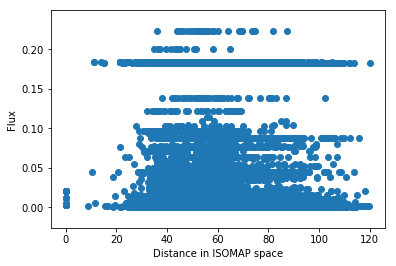

In [438]:
x = np.array(distances)
y = np.array(fluxes)
plt.scatter(x, y)
plt.xlabel('Distance in ISOMAP space')
plt.ylabel('Flux')

## Calmodulin Baseline MFPT

#### MFPT vs RMSD Plots

In [444]:
# import the msm, raw XYZ coordinates, and the cluster assignments
cal_msm = msmUtils.load(base + '\\apo_calmodulin\msm\msm.pkl')
X_rd = np.load(base + '\\apo_calmodulin\\reduced_dimension\\X_isomap_30_10_15000.dat')
cluster_assignments = np.loadtxt(base + '\\apo_calmodulin\msm\msm_clustering_labels.csv', delimiter=',')
chosen_indices = np.loadtxt(base + '\\apo_calmodulin\msm\indices_15000.csv', delimiter=',')

In [445]:
# Collect MFPT
cal_mfpt_matrix = (mfpts(cal_msm) + mfpts(cal_msm).T)/2

In [453]:
# Parameters for MFPT plots
num_frames = X_rd.shape[0]
num_points = 5000

In [454]:
distances = []
mfpt_times = []
for p in range(num_points):
    frame_pair = np.random.randint(low=0, high=num_frames-1, size=2) # frame number in sim_data
    true_frame_pair = (int(chosen_indices[frame_pair[0]]), int(chosen_indices[frame_pair[1]])) # corresponding original frame numbers
    msm_frame_pair = (cal_msm.mapping_[cluster_assignments[true_frame_pair[0]]], cal_msm.mapping_[cluster_assignments[true_frame_pair[1]]])
    rd_distance = np.linalg.norm(X_rd[frame_pair[0],:] - X_rd[frame_pair[1], :])
    if msm_frame_pair[0] != msm_frame_pair[1] and cal_mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]] >= 0 and rd_distance < 1000:
        distances.append(rd_distance)
        mfpt_times.append(cal_mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]])

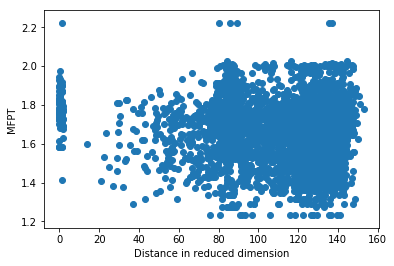

In [455]:
plt.scatter(np.array(distances), np.log(np.log(np.array(mfpt_times))))
plt.xlabel('Distance in reduced dimension')
plt.ylabel('MFPT')